In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(f"Размер изображения: {image_gray.shape}")

Размер изображения: (275, 183)


In [3]:
# 1. Подбор параметров region growing
def homo_average(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return True
    av_val = img[mask > 0].mean()
    return abs(av_val - img[point]) <= T

def homo_variance(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return True
    region_pixels = img[mask > 0]
    variance = np.var(region_pixels)
    return abs(img[point] - np.mean(region_pixels)) <= T and variance <= 100

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1

    for _ in range(1000):
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and np.any(mask[i - r:i + r + 1, j - r:j + r + 1]):
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        if np.count_nonzero(local_mask) == 0:
            break
        mask = cv2.bitwise_or(mask, local_mask)

    return mask * 255

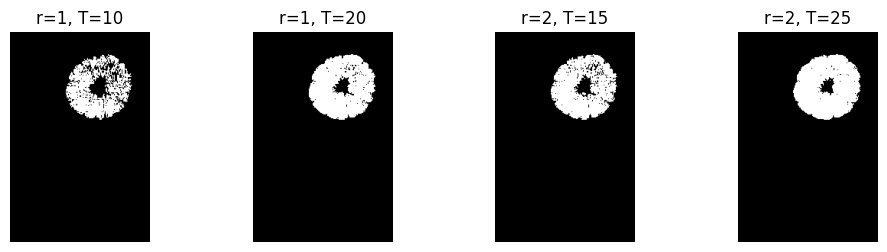

In [4]:
seed_point = (100, 100)
parameters = [(1, 10), (1, 20), (2, 15), (2, 25)]

plt.figure(figsize=(12, 6))

for i, (r, T) in enumerate(parameters):
    mask = region_growing(image_gray, seed_point, homo_average, r, T)
    plt.subplot(2, 4, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'r={r}, T={T}')
    plt.axis('off')

(np.float64(-0.5), np.float64(182.5), np.float64(274.5), np.float64(-0.5))

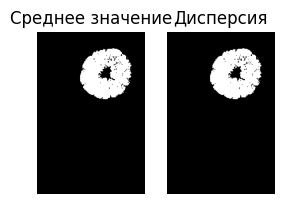

In [5]:
# 2. Сравнение критериев однородности
mask_avg = region_growing(image_gray, seed_point, homo_average, 2, 20)
mask_var = region_growing(image_gray, seed_point, homo_variance, 2, 20)

plt.subplot(2, 4, 5)
plt.imshow(mask_avg, cmap='gray')
plt.title('Среднее значение')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(mask_var, cmap='gray')
plt.title('Дисперсия')
plt.axis('off')

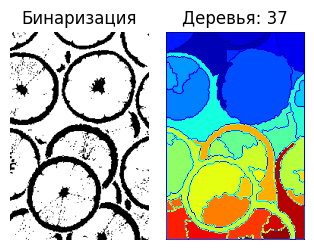

In [6]:
# 3. Watershed для подсчета деревьев
ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
image_color = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(image_color, markers)
tree_count = len(np.unique(markers)) - 2

plt.subplot(2, 4, 7)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(markers, cmap='jet')
plt.title(f'Деревья: {tree_count}')
plt.axis('off')

plt.tight_layout()
plt.show()